In [1]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   # suppress tensorflow warnings
from tensorflow.keras.models import load_model
import pandas as pd
pd.options.mode.chained_assignment = None  # suppress pd warnings
sys.path.append('../')

from src.utils import (
    get_Trastuzumab_len_10_H3_seq,
    generate_new_seqs_from_probabilities,
    get_observed_frequnecies_from_list_of_seqs,
    make_nice_df_from_seqs,
    join_dfs,
    get_target_edit_distance_counts
)
from src.plotting import (
    plot_logo_plot_from_normalised_matrix
)
from src.library_design_methods.blosum import (
    get_20x20_blosum_matrix,
    get_blosum_h3_AA_probs,
    get_blosum_probs_for_seq
)
from src.classifiers.dataset import (
    get_X_y
)
from src.classifiers.evaluate import (
    plot_predictions_histogram_stack_editdist
)

seq_to_mutate = get_Trastuzumab_len_10_H3_seq()

### Generate sequences with e.g. BLOSUM

Observed edit distance distribution (edit: count) scaled to target total:
{1: 0, 2: 3, 3: 8, 4: 28, 5: 98, 6: 220, 7: 313, 8: 235, 9: 77, 10: 18}
Max tries reached. 999 out of 1,000 sequences made


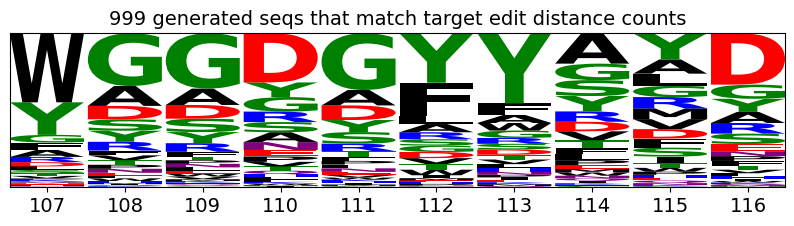

In [2]:
# choose the number of sequences you want to generate
num_new_seqs_to_generate = 1000

# get sampling weights for each AA at each position
blosum_matrix      = get_20x20_blosum_matrix(45)
blosum_h3_AA_probs = get_blosum_h3_AA_probs()
sampling_probs     = get_blosum_probs_for_seq(seq_to_mutate, blosum_matrix, blosum_h3_AA_probs)

# say we wish to match the edit distance of some experimental positive data
# note, you could instead simply specify how many sequences you want to generate at each edit distance
data = os.path.abspath("../data/affinity_data/her2/her2_aff_large/processed/remove_overlap/random_split/0.7_0.15_0.15/")
train = pd.read_csv(os.path.join(data, "train.csv"))
val = pd.read_csv(os.path.join(data, "val.csv"))
test = pd.read_csv(os.path.join(data, "test.csv"))
experimental_data = join_dfs([train, val, test])
target_counts = get_target_edit_distance_counts(experimental_data, target_total=num_new_seqs_to_generate, positives_only=True)
print(f"Observed edit distance distribution (edit: count) scaled to target total:\n{dict(sorted(target_counts.items()))}")

# generate new sequences
max_tries=num_new_seqs_to_generate*10
new_library_match_target_counts = generate_new_seqs_from_probabilities(sampling_probs, num_new_seqs_to_generate, target_counts=target_counts,
                                                                       max_tries=max_tries, original_seq=seq_to_mutate)
new_library_match_target_counts_df = make_nice_df_from_seqs(new_library_match_target_counts, original_seq=seq_to_mutate)

new_library_match_target_counts_freqs = get_observed_frequnecies_from_list_of_seqs(new_library_match_target_counts)
plot_logo_plot_from_normalised_matrix(new_library_match_target_counts_freqs, title=f"{new_library_match_target_counts_df.shape[0]:,} generated seqs that match target edit distance counts")

### Predicted enrichment

Note, when trained on our small example dataset, the CNN appears to learn that smaller edit distances from Trastuzumab are more likely to continue to bind HER2.

32/32 [==============================] - 0s 3ms/step


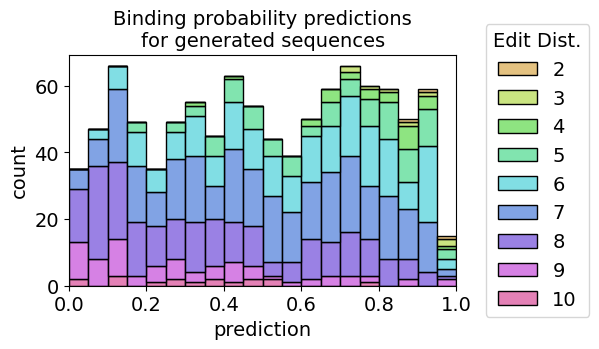

In [3]:
# load trained cnn
cnn_weights_file = os.path.abspath("../data/affinity_data/example/cnn_weights.h5")
CNN = load_model(cnn_weights_file)

# add "unknown" label column to new_library_match_target_counts_df
new_library_match_target_counts_df["label"] = "unknown"

# prepare data for CNN
X_evaluate,  y_evaluate  = get_X_y(new_library_match_target_counts_df)

# predict
predictions = CNN.predict(X_evaluate)
new_library_match_target_counts_df["predictions"] = predictions

# plot predictions
plot_predictions_histogram_stack_editdist(new_library_match_target_counts_df,
                                          title="Binding probability predictions\nfor generated sequences")